In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

### In this notebook, I will select a stellar mass complete sample of spiral galaxies

Task 1 is to load the relevant data

In [2]:
# GZ2 data:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [20]:
# Supplementary data
#mendel_masses = Table.read('../fits/Simard+Mendel/mendel_masses.fits')
mendel_data = Table.read('../fits/Simard+Mendel/mendel_dusty.fits')
samples = Table.read('../fits/sparcfire/sparcfire_samples.fits')
axial_data = Table.read('../fits/Axial_ratios/dr7_isoAB_matched.fits')

In [62]:
# Select the spirals:
def remove_inf(data):
    data[np.isfinite(data) == False] = -999
    return data 

p_spiral = remove_inf(gz2_data['t01_smooth_or_features_a02_'
                               'features_or_disk_debiased_rh']*
                      gz2_data['t02_edgeon_a05_no_debiased_rh']*
                      gz2_data['t04_spiral_a08_spiral_debiased'])

N_spiral = remove_inf(gz2_data['t04_spiral_a08_spiral_count']
                    - gz2_data['t11_arms_number_a37_cant_tell_count'])

axial_ratio = remove_inf(axial_data['isoB_g']/axial_data['isoA_g'])

spiral_ok = np.all([p_spiral>=0.5,N_spiral>=5,axial_ratio>=0.4],axis=0)

normal_depth = np.array(['coadd' not in r for r in gz2_data['sample']])
redshift_ok = np.all([gz2_data['REDSHIFT_1'] >= 0.02,
                      gz2_data['REDSHIFT_1'] <= 0.055],axis=0)

In [46]:
# match up the mass data:
from combining_catalogues import match_ids, make_matched_catalogue

ids_ = match_ids(gz2_data,mendel_data,'dr7objid','objID')
mendel_matched = make_matched_catalogue(gz2_data,mendel_data,ids_)
mendel_matched.remove_column('All')
mendel_matched['dr7objid'] = gz2_data['dr7objid']
mendel_matched['bulge+disc'] = np.log10(10**mendel_matched['logMb'] 
                                      + 10**mendel_matched['logMd'])

mendel_matched.write('../fits/Simard+Mendel/mendel_matched.fits',
                     overwrite=True)

248883 galaxies in the reference catalogue
657996 galaxies in the match catalogue
---> 237996 matches in total


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


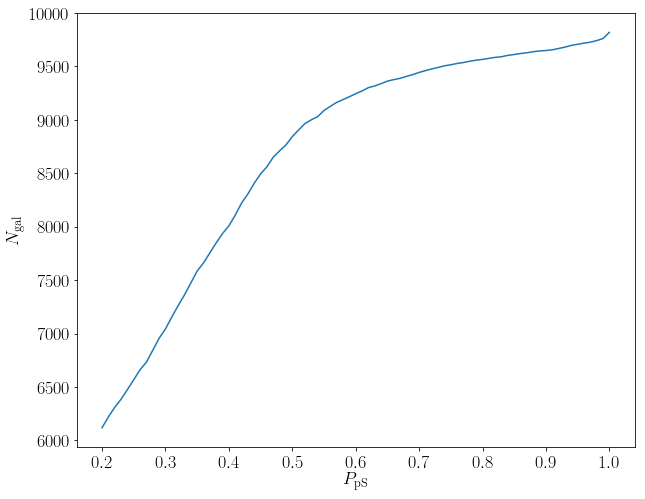

In [100]:
sample_ok = np.all([redshift_ok,normal_depth,spiral_ok],axis=0)

p_limits = np.linspace(0.2,1,81)
N_ok = []

for p_limit in p_limits:
    p_ok = np.all([mendel_matched['PpS'][sample_ok] <= p_limit,
                   np.isfinite(mendel_matched['bulge+disc'][sample_ok])],
                   axis=0)
    N_ok.append(p_ok.sum())
    
_ = plt.plot(p_limits,N_ok)
_ = plt.xlabel('$P_\mathrm{pS}$')
_ = plt.ylabel('$N_\mathrm{gal}$')

33831/248883 normal depth spirals have masses!


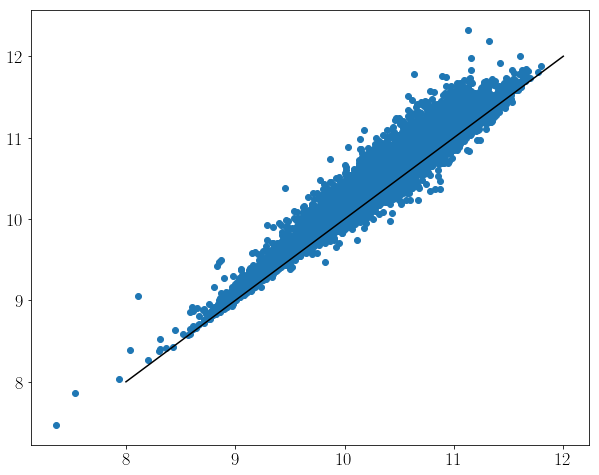

In [107]:
from luminosities_magnitudes_and_distances import Mag_to_lum, lum_to_solar

mass_total = remove_inf(mendel_masses['bulge+disc'])
mass_fit_ok = mendel_matched['Type'] == 3
mass_fit_ok = np.all([mendel_matched['PpS'] <= 0.5,
                      np.isfinite(mendel_matched['bulge+disc'])],
                     axis=0)
sample_ok = np.all([mass_fit_ok,normal_depth,spiral_ok],axis=0)

plt.scatter(mendel_matched['logMt'][sample_ok],
            mendel_matched['bulge+disc'][sample_ok])

plt.plot([8,12],[8,12],'k-')

print('{}/{} normal depth spirals have masses!'.format(sample_ok.sum(),
                                                       len(sample_ok)))

In [123]:
from luminosities_magnitudes_and_distances import Mag_to_lum, lum_to_solar, mag_to_Mag

def pozzetti_mass_completeness(redshifts,Mags,masses,z_lims=(0.02,0.025),
                               mag_limit=17):
    in_redshift = np.all([redshifts >= z_lims[0],redshifts <= z_lims[1]],
                         axis=0)
    
    redshifts_subset = redshifts[in_redshift]
    masses_subset = masses[in_redshift]
    Mags_subset = Mags[in_redshift]
    
    log_Lsolar = lum_to_solar(Mag_to_lum(Mags_subset,6185.19))
    logML = masses_subset - log_Lsolar
    
    Mag_limits = mag_to_Mag(mag_limit,redshifts_subset)
    lum_limits = lum_to_solar(Mag_to_lum(Mag_limits,6815.19))
    mass_limits = logML + np.squeeze(lum_limits)
    
    faintest_20_line = np.percentile(Mags_subset,80)
    in_faintest_20 = Mags_subset >= faintest_20_line
    mass_completeness = np.percentile(mass_limits[in_faintest_20],95)
    return mass_completeness, np.mean(redshifts_subset)


def pozzetti_mass_completeness_upper(redshifts,Mags,masses,z_lims=(0.02,0.025),
                                     mag_limit=14):
    in_redshift = np.all([redshifts >= z_lims[0],redshifts <= z_lims[1]],
                         axis=0)
    
    redshifts_subset = redshifts[in_redshift]
    masses_subset = masses[in_redshift]
    Mags_subset = Mags[in_redshift]
    
    log_Lsolar = lum_to_solar(Mag_to_lum(Mags_subset,6185.19))
    logML = masses_subset - log_Lsolar
    
    Mag_limits = mag_to_Mag(mag_limit,redshifts_subset)
    lum_limits = lum_to_solar(Mag_to_lum(Mag_limits,6815.19))
    mass_limits = logML + np.squeeze(lum_limits)
    
    brightest_20_line = np.percentile(Mags_subset,20)
    in_brightest_20 = Mags_subset <= brightest_20_line
    mass_completeness = np.percentile(mass_limits[in_brightest_20],5)
    
    return mass_completeness, np.mean(redshifts_subset)

y_upper=2.57+-0.09 (x) + 14.33+-0.13
y_lower=2.28+-0.16 (x) + 12.97+-0.23


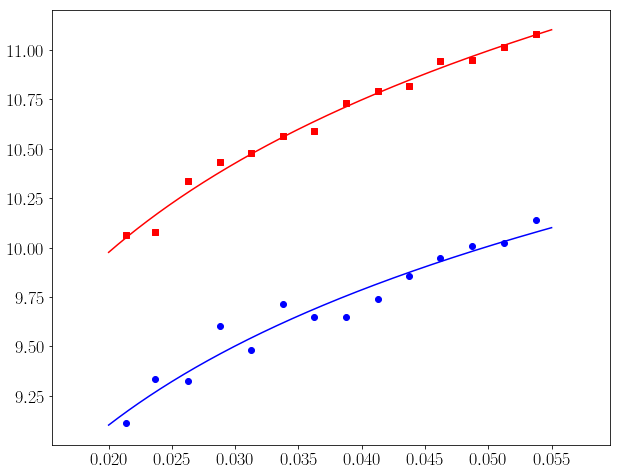

In [149]:
from scipy.optimize import curve_fit

def log(x,m,c):
    return m*np.log10(x) + c

zs = np.linspace(0.02,0.055,15)

z_bins = []
mass_lower_limits = []
mass_upper_limits = []

redshifts = np.array(gz2_data['REDSHIFT_1'][sample_ok],dtype=np.float)
Mags = np.array(gz2_data['PETROMAG_MR'][sample_ok],dtype=np.float)
masses = np.array(mendel_matched['bulge+disc'][sample_ok],dtype=np.float)

for z1, z2 in zip(zs[:-1],zs[1:]):
    
    mass_lower, z_ = pozzetti_mass_completeness(redshifts,Mags,masses,(z1,z2))
    mass_upper, _ = pozzetti_mass_completeness_upper(redshifts,Mags,masses,(z1,z2))
    
    z_bins.append(z_)
    mass_lower_limits.append(mass_lower)
    mass_upper_limits.append(mass_upper)
    
#######################################


_ = plt.scatter(z_bins,mass_lower_limits,marker='o',color='b')
_ = plt.scatter(z_bins,mass_upper_limits,marker='s',color='r')

p_lower, p_lower_cov = curve_fit(log,z_bins,mass_lower_limits)
p_lower_error = np.sqrt(np.diag(p_lower_cov))
p_upper, p_upper_cov = curve_fit(log,z_bins,mass_upper_limits)
p_upper_error = np.sqrt(np.diag(p_upper_cov))

x_guide = np.linspace(zs[0],zs[-1],1000)

_ = plt.plot(x_guide,log(x_guide,*p_upper),color='r')
_ = plt.plot(x_guide,log(x_guide,*p_lower),color='b')

upper_list = np.round([p_upper[0],p_upper_error[0],
                       p_upper[1],p_upper_error[1]],decimals=2)

lower_list = np.round([p_lower[0],p_lower_error[0],
                       p_lower[1],p_lower_error[1]],decimals=2)

print('y_upper={}+-{} (x) + {}+-{}'.format(*upper_list))

print('y_lower={}+-{} (x) + {}+-{}'.format(*lower_list))

#### How many galaxies are in our samples?

In [150]:
class GetLimits():
    
    def __init__(self,redshift,Mag,mass,z_limits=(0.02,0.055),
                 mag_upper=14,mag_lower=17,
                 p_lower=p_lower,p_upper=p_upper):
        self.redshift = redshift
        self.Mag = Mag
        self.mass = mass
        self.z_limits = z_limits
        self.lower_Mag_limit = mag_to_Mag(mag_lower,redshift)
        self.upper_Mag_limit = mag_to_Mag(mag_upper,redshift)
        self.lower_mass_limit = log(redshift,*p_lower)
        self.upper_mass_limit = log(redshift,*p_upper)
        
    def in_redshift_limit(self):
        in_redshift_lim = np.all([self.redshift >= self.z_limits[0],
                                    self.redshift <= self.z_limits[1]],axis=0)
        return in_redshift_lim
    
    def in_Mag_limit(self):
        in_Mag_lim = np.all([self.Mag <= self.lower_Mag_limit,
                             self.Mag >= self.upper_Mag_limit],axis=0)
        return in_Mag_lim
    
    def in_mass_limit(self):
        in_mass_lim = np.all([self.mass >= self.lower_mass_limit,
                             self.mass <= self.upper_mass_limit],axis=0)
        return in_mass_lim

In [152]:
lims = GetLimits(gz2_data['REDSHIFT_1'][sample_ok],
                 gz2_data['PETROMAG_MR'][sample_ok],
                 mendel_matched['bulge+disc'][sample_ok],
                 z_limits=(0.02,0.055))

in_zl = lims.in_redshift_limit()
in_vl = lims.in_redshift_limit()*lims.in_Mag_limit()
in_ml = lims.in_redshift_limit()*lims.in_Mag_limit()*lims.in_mass_limit()

print('z-limited spirals: {}'.format(in_zl.sum()))
print('lum.-limited spirals: {}'.format(in_vl.sum()))
print('M*-limited spirals: {}'.format(in_ml.sum()))

z-limited spirals: 8842
lum.-limited spirals: 8798
M*-limited spirals: 5885


../astro_codes/luminosities_magnitudes_and_distances.py:21: RuntimeWarning: divide by zero encountered in log10
  Mag = mag - 5*(np.log10(D/(u.pc))-1)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/astropy/units/quantity.py:605: RuntimeWarning: divide by zero encountered in log10
  out = function(inputs[0], obj_array)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


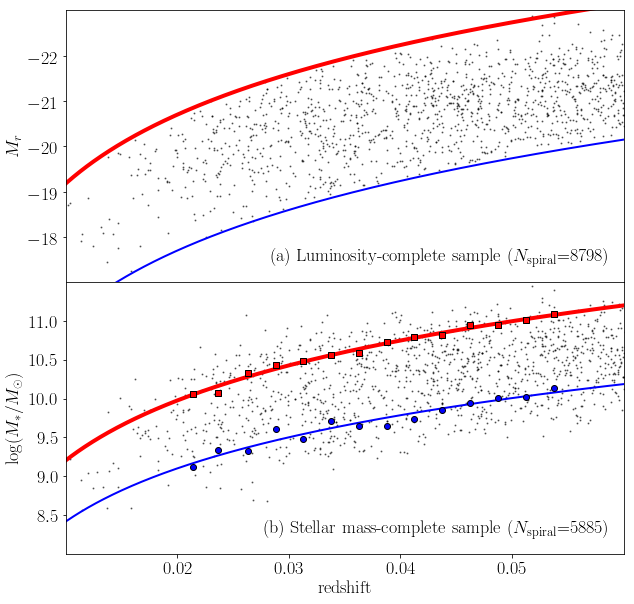

In [153]:
def plot_subset(ax,x,y,N_subset=4000,**kwargs):
    np.random.seed(0)
    N_galaxies = len(x)
    galaxy_indices = range(N_galaxies)
    random_subset = np.random.choice(N_galaxies,N_subset,replace=False)
    _ = ax.scatter(x[random_subset],y[random_subset],**kwargs)
    return None

fig, axarr = plt.subplots(2,1,figsize=(10,10),sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

in_z = np.all([galaxy_table['redshift'] >= 0.01,galaxy_table['redshift'] <= 0.06],
              axis=0)

z_guide = np.linspace(0,0.1,1000)
upper_Mag_guide = mag_to_Mag(14,z_guide)
lower_Mag_guide = mag_to_Mag(17,z_guide)
lower_mass_guide = log(z_guide,*p_lower)
upper_mass_guide = log(z_guide,*p_upper)

ax = axarr[0]
_ = plot_subset(ax,gz2_data['REDSHIFT_1'][sample_ok],
                gz2_data['PETROMAG_MR'][sample_ok],
                s=1,color='k',rasterized=True,alpha=0.5)
_ = ax.plot(z_guide,lower_Mag_guide,lw=2,color='b')
_ = ax.plot(z_guide,upper_Mag_guide,lw=4,color='r')

_ = ax.set_ylim(-17,-23)
_ = ax.set_ylabel('$M_r$')


ax = axarr[1]
_ = plot_subset(ax,gz2_data['REDSHIFT_1'][sample_ok],
                mendel_matched['bulge+disc'][sample_ok],
                s=1,color='k',rasterized=True,alpha=0.5,zorder=0)

_ = ax.plot(z_guide,lower_mass_guide,lw=2,color='b',zorder=1)
_ = ax.plot(z_guide,upper_mass_guide,lw=4,color='r',zorder=1)

_ = ax.scatter(z_bins,mass_lower_limits,marker='o',color='b',lw=1,edgecolor='k',
               zorder=2)
_ = ax.scatter(z_bins,mass_upper_limits,marker='s',color='r',lw=1,edgecolor='k',
               zorder=2)

_ = ax.set_ylim(8,11.5)
_ = ax.set_ylabel('$\log(M_*/M_\odot)$')



_ = axarr[1].set_xlabel('redshift')
_ = axarr[1].set_xlim(0.01,0.06)

_ = axarr[0].text(0.975,0.05,
    '(a) Luminosity-complete sample ($N_\mathrm{{spiral}}$={})'.format(in_vl.sum()),
                 transform=axarr[0].transAxes,ha='right',va='bottom')
_ = axarr[1].text(0.975,0.05,
    '(b) Stellar mass-complete sample ($N_\mathrm{{spiral}}$={})'.format(in_ml.sum()),
                 transform=axarr[1].transAxes,ha='right',va='bottom')

#fig.savefig('paper_figures/sample_limiting.pdf')

#### Next task: calculate the $V_\mathrm{max}$ correction

In [160]:
def invert_log(mass,m,c):
    z_limit =  10**((mass-c)/m)
    return z_limit

ml_masses = mendel_matched['bulge+disc'][sample_ok][in_ml]

lower_z_limits = invert_log(ml_masses,*p_upper)
upper_z_limits = invert_log(ml_masses,*p_lower)

z_limits = (0.02, 0.055)
lower_z_limits[lower_z_limits < z_limits[0]] = z_limits[0]
upper_z_limits[upper_z_limits > z_limits[1]] = z_limits[1]

def compute_Vmax(z,scale=True):
    z1, z2 = z
    Vmax = z2**3 - z1**3
    Vmax_weighting = 1/Vmax
    if scale is True:
        Vmax_weighting = Vmax_weighting/np.min(Vmax_weighting)
    return Vmax_weighting

In [161]:
vmax_weights = compute_Vmax((lower_z_limits,upper_z_limits))
log_weights = np.log10(vmax_weights)

5782/5885 have good weights! (98.2%)


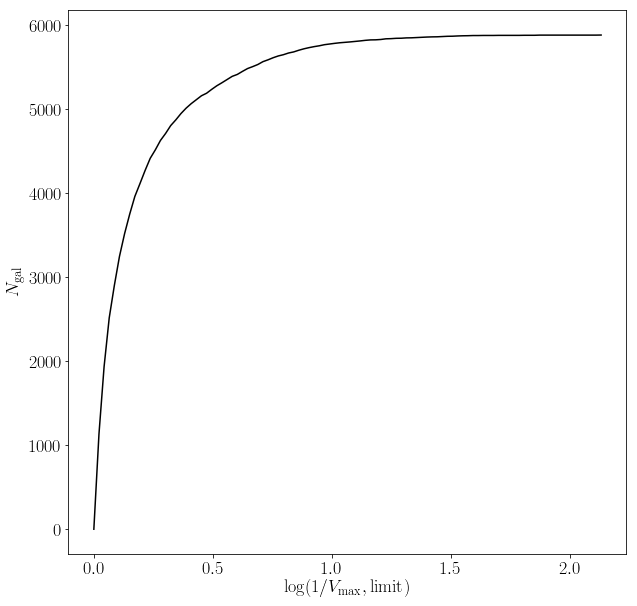

In [162]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

weight_limits = np.linspace(log_weights.min(),log_weights.max(),100)
sample_sizes = []
for weight_limit in weight_limits:
    in_sample = log_weights <= weight_limit
    sample_sizes.append(in_sample.sum())
    
_ = ax.plot(weight_limits,sample_sizes,color='k')
_ = ax.set_xlabel('$\log(1/V_\mathrm{max}, \mathrm{limit})$')
_ = ax.set_ylabel('$N_\mathrm{gal}$')

# Limit at 10:
vmax_ok = vmax_weights <= 10
print('{}/{} have good weights! ({}%)'.format(vmax_ok.sum(),len(vmax_ok),
                    100*np.round(vmax_ok.sum()/len(vmax_ok),decimals=3)))

5688/5885 in error tolerance (96.7%)


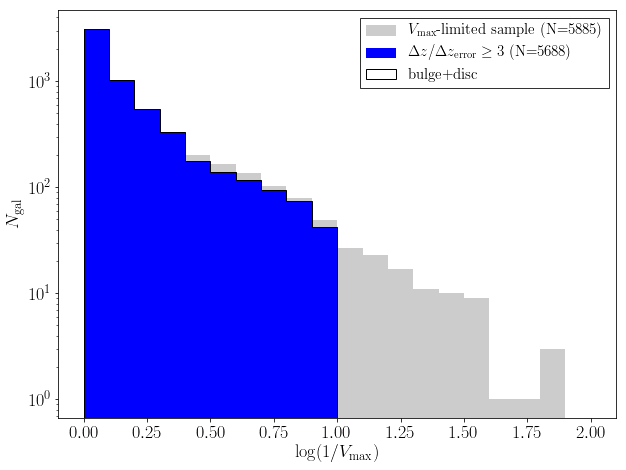

In [163]:
def invert_log_with_errors(mass,m,c,delta_m,delta_c):
    z_limit =  10**((mass-c)/m)
    z_err_c = 10**(mass/m)*(-1/m)*(10**(-c/m))*delta_c
    z_err_m = 10**(mass-c)*(-1/m**2)*(10**(1/m))*delta_m
    z_error = (z_err_m**2 + z_err_c**2)**0.5
    return z_limit, z_error


def compute_Vmax_with_errors(z,z_errors=None,scale=True,tolerance=1):
    z1, z2 = z
    Vmax = z2**3 - z1**3
    Vmax_weighting = 1/Vmax
    if scale is True:
        Vmax_weighting = Vmax_weighting/np.min(Vmax_weighting)
    if z_errors is None:
        return Vmax_weighting
    else:
        z1_error, z2_error = z_errors
        z_distance = z2 - z1
        z_error = (z1_error**2 + z2_error**2)**0.5
        z_mask = z_distance/z_error >= tolerance
        return Vmax_weighting, z_mask

lower_z_limits, lower_z_errors = invert_log_with_errors(ml_masses,
                                                   p_upper[0],p_upper[1],
                                        p_upper_error[0],p_upper_error[1])
upper_z_limits, upper_z_errors = invert_log_with_errors(ml_masses,
                                                   p_lower[0],p_lower[1],
                                        p_lower_error[0],p_lower_error[1])


low_z_mask = lower_z_limits < 0.02
high_z_mask = upper_z_limits > 0.055
lower_z_limits[low_z_mask] = 0.02
lower_z_errors[low_z_mask] = 0
upper_z_limits[high_z_mask] = 0.055
upper_z_errors[high_z_mask] = 0

vmax_weights, z_mask = compute_Vmax_with_errors((lower_z_limits,upper_z_limits),
                                           (lower_z_errors,upper_z_errors),
                                           tolerance=3)

log_weights = np.log10(vmax_weights)

bins = np.linspace(0,2,21)

fig = plt.figure(figsize=(10,7.5))
ax = plt.subplot(111)
_ = ax.hist(log_weights,bins,color='k',alpha=0.2,
            label='$V_\mathrm{{max}}$-limited sample (N={})'.format(len(z_mask)))
_ = ax.hist(log_weights[z_mask],bins,color='b',
            label=r'$\Delta z / \Delta z_\mathrm{{error}} \geq 3$ (N={})'.format(z_mask.sum()))
_ = ax.hist(log_weights[z_mask],bins,histtype='step',color='k')
_ = ax.set_yscale('log')
_ = ax.set_xlabel('$\log(1/V_\mathrm{max})$')
_ = ax.set_ylabel('$N_\mathrm{gal}$')
_ = ax.legend(loc='upper right',fontsize=15,fancybox=False,edgecolor='k')

print('{}/{} in error tolerance ({}%)'.format(z_mask.sum(),len(z_mask),
                    100*np.round(z_mask.sum()/len(z_mask),decimals=3)))

In [169]:
ml_table = Table()
ml_table['dr7objid'] = gz2_data['dr7objid'][sample_ok][in_ml]
ml_table['bulge_mass'] = mendel_matched['logMb'][sample_ok][in_ml]
ml_table['disc_mass'] = mendel_matched['logMd'][sample_ok][in_ml]
ml_table['bulge+disc_mass'] = mendel_matched['bulge+disc'][sample_ok][in_ml]
ml_table['vmax_weight'] = vmax_weights
ml_table['vmax_ok'] = z_mask

ml_table.write('fits/ml_table.fits',overwrite=True)

ids_ = match_ids(gz2_data,ml_table,'dr7objid','dr7objid')
ml_table_matched = make_matched_catalogue(gz2_data,ml_table,ids_)
ml_table_matched['dr7objid'] = gz2_data['dr7objid']
ml_table_matched['vmax_ok'] = ml_table_matched['vmax_ok'] == 1
ml_table_matched.write('fits/ml_table_matched.fits',overwrite=True)

248883 galaxies in the reference catalogue
5885 galaxies in the match catalogue
---> 5885 matches in total
